<a href="https://colab.research.google.com/github/sriramxdev/Cats-and-Dogs_Project/blob/main/cats_and_dogs_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification of Cats and Dogs using CNN


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam  # Fixed: Changed RMSprop to Adam since we use Adam
from sklearn.metrics import confusion_matrix, classification_report
import urllib.request
import zipfile
import time

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)


Num GPUs Available:  1
TensorFlow version: 2.18.0


### Download and Prepare the Dataset

In [ ]:
# Function to download and extract the dataset
def download_and_extract_dataset():
    # Create directories for the dataset
    base_dir = 'dataset'
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    # URL for the dataset (Microsoft Cats and Dogs dataset)
    url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

    # Path to save the downloaded zip file
    zip_path = os.path.join(base_dir, 'cats_and_dogs.zip')

    # Download the dataset if it doesn't exist
    if not os.path.exists(zip_path):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, zip_path)
        print("Download complete!")

    # Extract the dataset if not already extracted
    extract_dir = os.path.join(base_dir, 'PetImages')
    if not os.path.exists(extract_dir):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(base_dir)
        print("Extraction complete!")

    return base_dir

# Download and extract the dataset
base_dir = download_and_extract_dataset()


Download complete!
Extracting dataset...
Extraction complete!


In [ ]:
# Organize the dataset into train, validation, and test sets
def organize_dataset(base_dir):
    # Create directories for train, validation, and test sets
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')

    # Create subdirectories for cats and dogs in each set
    for dir_path in [train_dir, val_dir, test_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            os.makedirs(os.path.join(dir_path, 'cats'))
            os.makedirs(os.path.join(dir_path, 'dogs'))

    # If the dataset is already organized, return the directories
    if len(os.listdir(os.path.join(train_dir, 'cats'))) > 0:
        print("Dataset already organized.")
        return train_dir, val_dir, test_dir

    # Source directories for cats and dogs
    cats_dir = os.path.join(base_dir, 'PetImages', 'Cat')
    dogs_dir = os.path.join(base_dir, 'PetImages', 'Dog')

    # Function to remove corrupted images
    def is_valid_image(file_path):
        try:
            img = cv2.imread(file_path)
            return img is not None
        except:
            return False

    # Get list of valid cat and dog images
    cat_files = [f for f in os.listdir(cats_dir) if is_valid_image(os.path.join(cats_dir, f))]
    dog_files = [f for f in os.listdir(dogs_dir) if is_valid_image(os.path.join(dogs_dir, f))]

    # Shuffle the files
    random.shuffle(cat_files)
    random.shuffle(dog_files)

    # Split the files into train (70%), validation (15%), and test (15%) sets
    n_cats_train = int(0.7 * len(cat_files))
    n_cats_val = int(0.15 * len(cat_files))

    n_dogs_train = int(0.7 * len(dog_files))
    n_dogs_val = int(0.15 * len(dog_files))

    # Copy cat images to their respective directories
    for i, file in enumerate(cat_files):
        src = os.path.join(cats_dir, file)
        if i < n_cats_train:
            dst = os.path.join(train_dir, 'cats', file)
        elif i < n_cats_train + n_cats_val:
            dst = os.path.join(val_dir, 'cats', file)
        else:
            dst = os.path.join(test_dir, 'cats', file)
        os.link(src, dst)  # Create hard link instead of copying to save space

    # Copy dog images to their respective directories
    for i, file in enumerate(dog_files):
        src = os.path.join(dogs_dir, file)
        if i < n_dogs_train:
            dst = os.path.join(train_dir, 'dogs', file)
        elif i < n_dogs_train + n_dogs_val:
            dst = os.path.join(val_dir, 'dogs', file)
        else:
            dst = os.path.join(test_dir, 'dogs', file)
        os.link(src, dst)  # Create hard link instead of copying to save space

    print(f"Dataset organized into:\n"
          f"- Train: {len(os.listdir(os.path.join(train_dir, 'cats')))} cats, {len(os.listdir(os.path.join(train_dir, 'dogs')))} dogs\n"
          f"- Validation: {len(os.listdir(os.path.join(val_dir, 'cats')))} cats, {len(os.listdir(os.path.join(val_dir, 'dogs')))} dogs\n"
          f"- Test: {len(os.listdir(os.path.join(test_dir, 'cats')))} cats, {len(os.listdir(os.path.join(test_dir, 'dogs')))} dogs")

    return train_dir, val_dir, test_dir

# Organize the dataset
train_dir, val_dir, test_dir = organize_dataset(base_dir)


Dataset organized into:
- Train: 8748 cats, 8749 dogs
- Validation: 1874 cats, 1874 dogs
- Test: 1876 cats, 1876 dogs


### Data Visualization


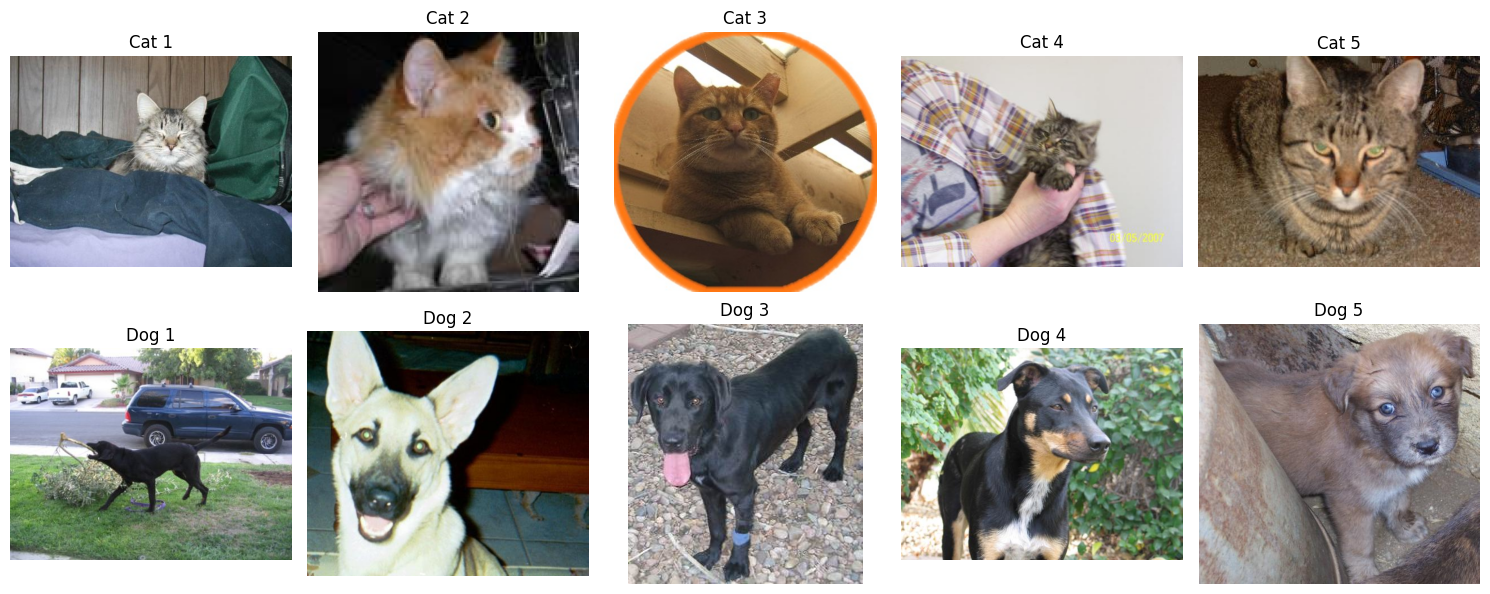

In [ ]:
# Function to display random images from the dataset
def display_random_images(directory, n=5):
    cats_dir = os.path.join(directory, 'cats')
    dogs_dir = os.path.join(directory, 'dogs')

    cat_files = random.sample(os.listdir(cats_dir), n)
    dog_files = random.sample(os.listdir(dogs_dir), n)

    plt.figure(figsize=(15, 6))

    # Display cat images
    for i, file in enumerate(cat_files):
        img_path = os.path.join(cats_dir, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title(f'Cat {i+1}')
        plt.axis('off')

    # Display dog images
    for i, file in enumerate(dog_files):
        img_path = os.path.join(dogs_dir, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        plt.subplot(2, n, n+i+1)
        plt.imshow(img)
        plt.title(f'Dog {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display random images from the training set
display_random_images(train_dir)


### 4. Data Preprocessing and Augmentation

In [ ]:
# Define image dimensions and batch size
# Using 299x299 resolution - optimal for high accuracy in image classification
IMG_WIDTH = 299
IMG_HEIGHT = 299
# Maximum batch size for dedicated 15GB GPU usage
BATCH_SIZE = 64  # Aggressive batch size to fully utilize 15GB GPU

print(f"Using image resolution: {IMG_WIDTH}x{IMG_HEIGHT}")
print(f"Batch size: {BATCH_SIZE} (maximized for dedicated 15GB GPU usage)")
print("299x299 with large batch size - optimized for maximum GPU utilization!")

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generators without augmentation for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Using image resolution: 299x299
Batch size: 64 (maximized for dedicated 15GB GPU usage)
299x299 with large batch size - optimized for maximum GPU utilization!
Found 17497 images belonging to 2 classes.
Found 3748 images belonging to 2 classes.
Found 3752 images belonging to 2 classes.


### Visualization

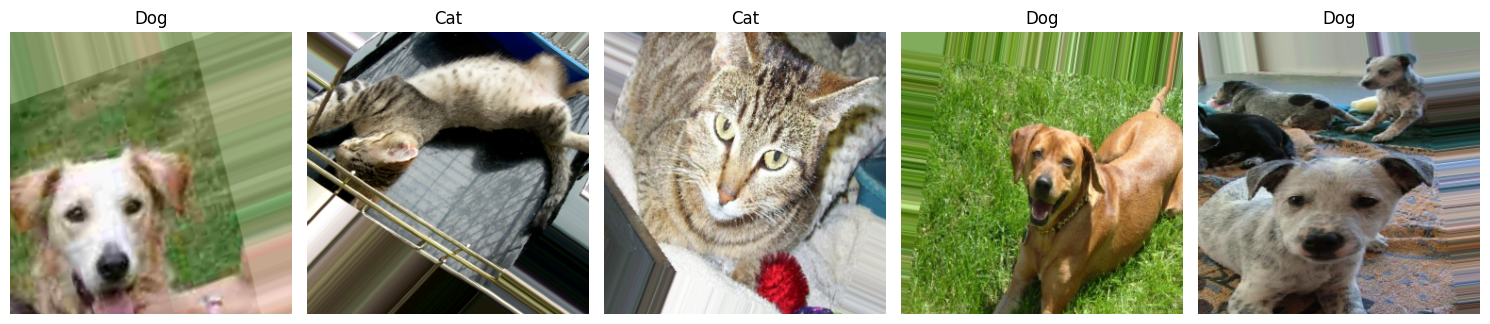

In [ ]:
# Function to display augmented images
def display_augmented_images():
    # Get a batch of images from the training generator
    x_batch, y_batch = next(train_generator)

    # Display 5 augmented images
    plt.figure(figsize=(15, 6))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(x_batch[i])
        plt.title('Cat' if y_batch[i] == 0 else 'Dog')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display augmented images
display_augmented_images()


### Build the CNN Model


In [ ]:
# Function to create the CNN model
def create_model():
    model = Sequential([
        # First convolutional block - enhanced
        Conv2D(96, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.1),

        # Second convolutional block - enhanced
        Conv2D(192, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.2),

        # Third convolutional block - enhanced
        Conv2D(384, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.2),

        # Fourth convolutional block - enhanced
        Conv2D(768, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.3),

        # Fifth convolutional block - enhanced
        Conv2D(768, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.3),

        # Sixth convolutional block - additional for high capacity
        Conv2D(1024, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.4),

        # Flatten and enhanced dense layers
        Flatten(),
        Dense(2048, activation='relu'),  # Larger dense layer
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.4),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model with Adam optimizer
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the enhanced model
model = create_model()

print(f"Enhanced model for dedicated 15GB GPU - Input shape: {IMG_HEIGHT}x{IMG_WIDTH}x3")
print("Maximum capacity model utilizing full GPU potential!")
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Enhanced model for dedicated 15GB GPU - Input shape: 299x299x3
Maximum capacity model utilizing full GPU potential!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 148, 148, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 192)  │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 73, 73, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 384)    │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 35, 35, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 35, 35, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 768)    │     2,654,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 768)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 768)    │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 768)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 768)    │     5,309,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 768)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 768)      │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 768)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 1024)     │     7,078,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,902,849 (102.63 MB)

 Trainable params: 26,896,385 (102.60 MB)

 Non-trainable params: 6,464 (25.25 KB)

### Train the Model

In [ ]:
# Create callbacks for training
callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),

    # Save the model with highest validation accuracy during training
    ModelCheckpoint('models/cats_dogs_final_model.h5',
                   monitor='val_accuracy',
                   save_best_only=True,
                   mode='max',
                   verbose=1,
                   save_weights_only=False),

    # Also save based on validation loss (backup model)
    ModelCheckpoint('models/cats_dogs_backup_model.h5',
                   monitor='val_loss',
                   save_best_only=True,
                   mode='min',
                   verbose=1),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss',
                     factor=0.2,
                     patience=3,
                     min_lr=1e-7,
                     verbose=1,
                     cooldown=1)
]

# Create models directory before training
if not os.path.exists('models'):
    os.makedirs('models')

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"Training with {steps_per_epoch} steps per epoch and {validation_steps} validation steps")

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Training with 273 steps per epoch and 58 validation steps


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5221 - loss: 1.0491

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))



Epoch 1: val_accuracy improved from -inf to 0.49919, saving model to models/cats_dogs_final_model.h5



Epoch 1: val_loss improved from inf to 0.69464, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.5222 - loss: 1.0482 - val_accuracy: 0.4992 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 2/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:09 918ms/step - accuracy: 0.6875 - loss: 0.5722

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.49919 to 0.50135, saving model to models/cats_dogs_final_model.h5



Epoch 2: val_loss improved from 0.69464 to 0.69337, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.6875 - loss: 0.5722 - val_accuracy: 0.5013 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5992 - loss: 0.6666
Epoch 3: val_accuracy improved from 0.50135 to 0.58917, saving model to models/cats_dogs_final_model.h5



Epoch 3: val_loss improved from 0.69337 to 0.67508, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.5993 - loss: 0.6665 - val_accuracy: 0.5892 - val_loss: 0.6751 - learning_rate: 0.0010
Epoch 4/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:16 942ms/step - accuracy: 0.5781 - loss: 0.5951
Epoch 4: val_accuracy did not improve from 0.58917

Epoch 4: val_loss did not improve from 0.67508
273/273 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.5781 - loss: 0.5951 - val_accuracy: 0.5832 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6631 - loss: 0.6216
Epoch 5: val_accuracy improved from 0.58917 to 0.68481, saving model to models/cats_dogs_final_model.h5



Epoch 5: val_loss improved from 0.67508 to 0.61677, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.6631 - loss: 0.6216 - val_accuracy: 0.6848 - val_loss: 0.6168 - learning_rate: 0.0010
Epoch 6/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:12 927ms/step - accuracy: 0.6875 - loss: 0.5429
Epoch 6: val_accuracy improved from 0.68481 to 0.69316, saving model to models/cats_dogs_final_model.h5



Epoch 6: val_loss improved from 0.61677 to 0.59897, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.6875 - loss: 0.5429 - val_accuracy: 0.6932 - val_loss: 0.5990 - learning_rate: 0.0010
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6908 - loss: 0.5898
Epoch 7: val_accuracy did not improve from 0.69316

Epoch 7: val_loss did not improve from 0.59897
273/273 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.6909 - loss: 0.5898 - val_accuracy: 0.6719 - val_loss: 0.6007 - learning_rate: 0.0010
Epoch 8/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:08 912ms/step - accuracy: 0.7031 - loss: 0.7688
Epoch 8: val_accuracy did not improve from 0.69316

Epoch 8: val_loss improved from 0.59897 to 0.59257, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.7031 - loss: 0.7688 - val_accuracy: 0.6791 - val_loss: 0.5926 - learning_rate: 0.0010
Epoch 9/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7192 - loss: 0.5650
Epoch 9: val_accuracy did not improve from 0.69316

Epoch 9: val_loss did not improve from 0.59257
273/273 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accuracy: 0.7192 - loss: 0.5649 - val_accuracy: 0.6681 - val_loss: 0.6551 - learning_rate: 0.0010
Epoch 10/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:04 900ms/step - accuracy: 0.7500 - loss: 0.5704
Epoch 10: val_accuracy did not improve from 0.69316

Epoch 10: val_loss improved from 0.59257 to 0.58704, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.7500 - loss: 0.5704 - val_accuracy: 0.6907 - val_loss: 0.5870 - learning_rate: 0.0010
Epoch 11/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7573 - loss: 0.5126
Epoch 11: val_accuracy did not improve from 0.69316

Epoch 11: val_loss did not improve from 0.58704
273/273 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.7574 - loss: 0.5126 - val_accuracy: 0.6091 - val_loss: 0.6660 - learning_rate: 0.0010
Epoch 12/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:03 895ms/step - accuracy: 0.7812 - loss: 0.4753
Epoch 12: val_accuracy did not improve from 0.69316

Epoch 12: val_loss did not improve from 0.58704
273/273 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.7812 - loss: 0.4753 - val_accuracy: 0.6247 - val_loss: 0.6519 - learning_rate: 0.0010
Epoch 13/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7775 - loss: 0.4816
Epoch 13: val_accuracy improved from 0.69316 to 0.77020, saving model to models/cats_dogs_final_model.h5



Epoch 13: val_loss improved from 0.58704 to 0.52926, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.7776 - loss: 0.4816 - val_accuracy: 0.7702 - val_loss: 0.5293 - learning_rate: 0.0010
Epoch 14/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:14 934ms/step - accuracy: 0.8906 - loss: 0.3079
Epoch 14: val_accuracy improved from 0.77020 to 0.77802, saving model to models/cats_dogs_final_model.h5



Epoch 14: val_loss improved from 0.52926 to 0.52400, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.8906 - loss: 0.3079 - val_accuracy: 0.7780 - val_loss: 0.5240 - learning_rate: 0.0010
Epoch 15/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8141 - loss: 0.4239
Epoch 15: val_accuracy improved from 0.77802 to 0.80900, saving model to models/cats_dogs_final_model.h5



Epoch 15: val_loss improved from 0.52400 to 0.41168, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.8141 - loss: 0.4239 - val_accuracy: 0.8090 - val_loss: 0.4117 - learning_rate: 0.0010
Epoch 16/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:10 920ms/step - accuracy: 0.8125 - loss: 0.3409
Epoch 16: val_accuracy did not improve from 0.80900

Epoch 16: val_loss did not improve from 0.41168
273/273 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.8125 - loss: 0.3409 - val_accuracy: 0.7893 - val_loss: 0.4351 - learning_rate: 0.0010
Epoch 17/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8353 - loss: 0.3824
Epoch 17: val_accuracy improved from 0.80900 to 0.83917, saving model to models/cats_dogs_final_model.h5



Epoch 17: val_loss improved from 0.41168 to 0.37535, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.8353 - loss: 0.3823 - val_accuracy: 0.8392 - val_loss: 0.3753 - learning_rate: 0.0010
Epoch 18/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:07 911ms/step - accuracy: 0.8906 - loss: 0.2825
Epoch 18: val_accuracy did not improve from 0.83917

Epoch 18: val_loss did not improve from 0.37535
273/273 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.8906 - loss: 0.2825 - val_accuracy: 0.8343 - val_loss: 0.3915 - learning_rate: 0.0010
Epoch 19/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8556 - loss: 0.3496
Epoch 19: val_accuracy improved from 0.83917 to 0.88120, saving model to models/cats_dogs_final_model.h5



Epoch 19: val_loss improved from 0.37535 to 0.29741, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.8557 - loss: 0.3496 - val_accuracy: 0.8812 - val_loss: 0.2974 - learning_rate: 0.0010
Epoch 20/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:06 905ms/step - accuracy: 0.9219 - loss: 0.2156
Epoch 20: val_accuracy improved from 0.88120 to 0.88281, saving model to models/cats_dogs_final_model.h5



Epoch 20: val_loss improved from 0.29741 to 0.29065, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.9219 - loss: 0.2156 - val_accuracy: 0.8828 - val_loss: 0.2906 - learning_rate: 0.0010
Epoch 21/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8755 - loss: 0.3078
Epoch 21: val_accuracy did not improve from 0.88281

Epoch 21: val_loss did not improve from 0.29065
273/273 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - accuracy: 0.8755 - loss: 0.3078 - val_accuracy: 0.8244 - val_loss: 0.4009 - learning_rate: 0.0010
Epoch 22/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:01 887ms/step - accuracy: 0.8438 - loss: 0.3834
Epoch 22: val_accuracy did not improve from 0.88281

Epoch 22: val_loss did not improve from 0.29065
273/273 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.8438 - loss: 0.3834 - val_accuracy: 0.8335 - val_loss: 0.3802 - learning_rate: 0.0010
Epoch 23/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8750 - loss: 0.2975
Epoch 23: val_accuracy improved from 0.88281 to 0.89116, saving model to models/cats_dogs_final_model.h5



Epoch 23: val_loss improved from 0.29065 to 0.25474, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.8750 - loss: 0.2974 - val_accuracy: 0.8912 - val_loss: 0.2547 - learning_rate: 0.0010
Epoch 24/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:10 921ms/step - accuracy: 0.8750 - loss: 0.2748
Epoch 24: val_accuracy did not improve from 0.89116

Epoch 24: val_loss did not improve from 0.25474
273/273 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.8750 - loss: 0.2748 - val_accuracy: 0.8858 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 25/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8920 - loss: 0.2559
Epoch 25: val_accuracy improved from 0.89116 to 0.89305, saving model to models/cats_dogs_final_model.h5



Epoch 25: val_loss did not improve from 0.25474
273/273 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.8920 - loss: 0.2559 - val_accuracy: 0.8930 - val_loss: 0.2717 - learning_rate: 0.0010
Epoch 26/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:09 917ms/step - accuracy: 0.8594 - loss: 0.3378
Epoch 26: val_accuracy did not improve from 0.89305

Epoch 26: val_loss did not improve from 0.25474

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
273/273 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.8594 - loss: 0.3378 - val_accuracy: 0.8930 - val_loss: 0.2743 - learning_rate: 0.0010
Epoch 27/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9089 - loss: 0.2184
Epoch 27: val_accuracy improved from 0.89305 to 0.94127, saving model to models/cats_dogs_final_model.h5



Epoch 27: val_loss improved from 0.25474 to 0.15069, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.9089 - loss: 0.2184 - val_accuracy: 0.9413 - val_loss: 0.1507 - learning_rate: 2.0000e-04
Epoch 28/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:12 928ms/step - accuracy: 0.9062 - loss: 0.1581
Epoch 28: val_accuracy improved from 0.94127 to 0.94208, saving model to models/cats_dogs_final_model.h5



Epoch 28: val_loss did not improve from 0.15069
273/273 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.9062 - loss: 0.1581 - val_accuracy: 0.9421 - val_loss: 0.1508 - learning_rate: 2.0000e-04
Epoch 29/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9274 - loss: 0.1833
Epoch 29: val_accuracy improved from 0.94208 to 0.94289, saving model to models/cats_dogs_final_model.h5



Epoch 29: val_loss improved from 0.15069 to 0.13754, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.9274 - loss: 0.1833 - val_accuracy: 0.9429 - val_loss: 0.1375 - learning_rate: 2.0000e-04
Epoch 30/50
  1/273 ━━━━━━━━━━━━━━━━━━━━ 4:12 929ms/step - accuracy: 0.9375 - loss: 0.2031
Epoch 30: val_accuracy improved from 0.94289 to 0.94397, saving model to models/cats_dogs_final_model.h5



Epoch 30: val_loss improved from 0.13754 to 0.13699, saving model to models/cats_dogs_backup_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.9375 - loss: 0.2031 - val_accuracy: 0.9440 - val_loss: 0.1370 - learning_rate: 2.0000e-04
Epoch 31/50
114/273 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - accuracy: 0.9264 - loss: 0.1882

### Model Evaluation

In [ ]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


In [ ]:
# Load the saved model from training
try:
    trained_model = load_model('models/cats_dogs_final_model.h5')

    # Evaluate the trained model on the test set
    test_generator.reset()
    test_loss, test_accuracy = trained_model.evaluate(test_generator)
    print(f"Final Model Test Accuracy: {test_accuracy:.4f}")
    print(f"Final Model Test Loss: {test_loss:.4f}")

    # Also show current model performance for comparison
    test_generator.reset()  # Reset again for fair comparison
    current_test_loss, current_test_accuracy = model.evaluate(test_generator)
    print(f"\nCurrent Model Test Accuracy: {current_test_accuracy:.4f}")
    print(f"Current Model Test Loss: {current_test_loss:.4f}")

    print(f"\nImprovement from using saved model: {test_accuracy - current_test_accuracy:.4f}")

except FileNotFoundError:
    print("Trained model not found. Please run training first.")
    # Use current model instead
    test_generator.reset()
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Current Model Test Accuracy: {test_accuracy:.4f}")
    print(f"Current Model Test Loss: {test_loss:.4f}")

In [ ]:
# Load the trained model for predictions
trained_model = load_model('models/cats_dogs_final_model.h5')

# Generate predictions for the test set using the trained model
test_generator.reset()
predictions = trained_model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Get the true labels - ensure proper length matching
true_classes = test_generator.classes[:len(predicted_classes)]  # Fixed: Match lengths

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix - Trained Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report (Final Model):")
print(classification_report(true_classes, predicted_classes, target_names=['Cat', 'Dog']))

### Visualize Model Predictions


In [ ]:
# Function to display random test images with predictions using the trained model
def display_predictions(n=5):
    # Load the trained model
    trained_model = load_model('models/cats_dogs_final_model.h5')

    # Reset the test generator
    test_generator.reset()

    # Get a batch of test images
    x_batch, y_batch = next(test_generator)

    # Make predictions on the batch using the trained model
    predictions = trained_model.predict(x_batch)

    # Display images with predictions
    plt.figure(figsize=(15, 6))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(x_batch[i])

        # Get the true and predicted labels
        true_label = 'Cat' if y_batch[i] == 0 else 'Dog'
        pred_label = 'Cat' if predictions[i][0] < 0.5 else 'Dog'
        confidence = predictions[i][0] if pred_label == 'Dog' else 1 - predictions[i][0]

        # Set the title color based on whether the prediction is correct
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", color=color)
        plt.axis('off')

    plt.suptitle('Model Predictions on Test Images', fontsize=14)
    plt.tight_layout()
    plt.show()

# Display predictions on random test images using the trained model
display_predictions()

### Save the Model


In [ ]:
# Create the models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model in HDF5 format
model.save('models/cats_dogs_model.h5')
print("Model saved in HDF5 format.")

# Save the model in SavedModel format (TensorFlow's recommended format)
model.save('models/cats_dogs_savedmodel.keras')
print("Model saved in SavedModel format.")


### Test the Saved Model


In [ ]:
# Load the saved model from training
trained_model = load_model('models/cats_dogs_final_model.h5')

print("=== TRAINED MODEL EVALUATION ===")
print("Loading the model with highest validation accuracy from training.")

# Evaluate the trained model on the test set
test_generator.reset()
final_test_loss, final_test_accuracy = trained_model.evaluate(test_generator)
print(f"Final Model Test Accuracy: {final_test_accuracy:.4f}")
print(f"Final Model Test Loss: {final_test_loss:.4f}")

print(f"\nThe trained model is saved as: 'models/cats_dogs_final_model.h5'")
print("Use this model for inference and deployment.")